# Imports

In [2]:
root_path = "/mnt/c/Users/diego/OneDrive/Documentos/Idoven/Idoven-Data-Scientist/"
%cd $root_path

import os
import json
from typing import Generator, Optional, Tuple, List
import pickle


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score



import torch 
import torch.nn as nn
import math

from models.resnet101 import resnet101
from models.ECGNet import ECGNet

from utils.metrics import Metrics, AUC, metric_summary

import wandb




/mnt/c/Users/diego/OneDrive/Documentos/Idoven/Idoven-Data-Scientist


## Load from pickle

In [3]:
path_variable_pickle = 'data/variables_pickle/'
files = [
    ('X_train_scale', 'X_train_scale.pkl'),
    ('y_train', 'y_train.pkl'),
    ('X_test_scale', 'X_test_scale.pkl'),
    ('y_test', 'y_test.pkl'),
    ('X_val_scale', 'X_val_scale.pkl'),
    ('y_val', 'y_val.pkl')
    ]

for variable, file in files:
    with open(path_variable_pickle + file, 'rb') as f:
        globals()[variable] = pickle.load(f)


In [4]:
for f, _ in files:
    print(f"{f}: {eval(f).shape}")

X_train_scale: (17090, 1000, 12)
y_train: (17090, 5)
X_test_scale: (2159, 1000, 12)
y_test: (2159, 5)
X_val_scale: (2147, 1000, 12)
y_val: (2147, 5)


# Training

https://github1s.com/likith012/IMLE-Net/blob/HEAD/torch_train.py#L184-L243

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

In [5]:
class DataGen(torch.utils.data.Dataset):
    """Generates a torch Dataset object.

    Attributes
    ----------
    X: np.array
        Array of ECG signals.
    y: np.array
        Array of labels.
    batch_size: int, optional
        Batch size. (default: 32)

    """

    def __init__(self, X: np.array, y: np.array, batch_size: int = 32) -> None:
        self.batch_size = batch_size
        self.X = X
        self.y = y

    def __len__(self) -> int:
        return math.ceil(len(self.X) / self.batch_size)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        batch_x = self.X[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size : (idx + 1) * self.batch_size]
        return torch.tensor(batch_x, dtype=torch.float32), torch.tensor(
            batch_y, dtype=torch.float32
        )

In [6]:
def dump_logs(train_results: tuple, test_results: tuple, name: str):
    """Dumps the performance logs to a json file.

    Parameters
    ----------
    train_results: tuple
        Training results.
    test_results: tuple
        Testing results.
    name: str
        Name of the model.

    """

    logs = {
        "train_loss": train_results[0],
        "train_mean_accuracy": train_results[1],
        "train_roc_score": train_results[2],
        "test_loss": test_results[0],
        "test_mean_accuracy": test_results[1],
        "test_roc_score": test_results[2],
    }
    logs_path = os.path.join(os.getcwd(), "logs")
    os.makedirs(logs_path, exist_ok=True)

    with open(os.path.join(logs_path, f"{name}_train_logs.json"), "w") as json_file:
        json.dump({k: float(v.item()) for k, v in logs.items()}, json_file)
        # json.dump(logs, json_file)


def train_epoch(
    model: nn.Module,
    optimizer: torch.optim,
    loss_func,
    dataset,
    epoch: int,
    device: torch.device,
    loggr: bool = False,
) -> Tuple[float, float, float]:
    """Training of the model for one epoch.

    Parameters
    ----------
    model: nn.Module
        Model to be trained.
    optimizer: torch.optim
        Optimizer to be used.
    loss_func: torch.nn._Loss
        Loss function to be used.
    dataset: torch.utils.data.DataLoader
        Dataset to be used.
    epoch: int, optional
        The current epoch.
    device: torch.device
        Device to be used.
    loggr: bool, optional
        To log wandb metrics. (default: False)

    """

    model.train()

    pred_all = []
    loss_all = []
    gt_all = []

    for batch_step in tqdm(range(len(dataset)), desc="train"):
        batch_x, batch_y = dataset[batch_step]
        batch_x = batch_x.to(device)
        batch_x = batch_x.permute(0, 2, 1)
        batch_y = batch_y.to(device)

        pred = model(batch_x)
        pred_all.append(pred.cpu().detach().numpy())
        loss = loss_func(pred, batch_y)
        loss_all.append(loss.cpu().detach().item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        gt_all.extend(batch_y.cpu().detach().numpy())

        # Clean Memory
        del batch_x
        del batch_y
        gc.collect()
        torch.cuda.empty_cache()

    print("Epoch: {0}".format(epoch))
    print("Train loss: ", np.mean(loss_all), end="\n" * 2)

    pred_all = np.concatenate(pred_all, axis=0)
    _, mean_acc = Metrics(np.array(gt_all), pred_all)
    roc_score = roc_auc_score(np.array(gt_all), pred_all, average="macro")

    if loggr is not None:
        loggr.log({"train_mean_accuracy": mean_acc, "epoch": epoch})
        loggr.log({"train_roc_score": roc_score, "epoch": epoch})
        loggr.log({"train_loss": np.mean(loss_all), "epoch": epoch})

    return np.mean(loss_all), mean_acc, roc_score


def test_epoch(
    model: nn.Module,
    loss_func: torch.optim,
    dataset,
    epoch: int,
    device: torch.device,
    loggr: bool = False,
) -> Tuple[float, float, float]:
    """Testing of the model for one epoch.

    Parameters
    ----------
    model: nn.Module
        Model to be trained.
    loss_func: torch.nn.BCEWithLogitsLoss
        Loss function to be used.
    dataset: torch.utils.data.DataLoader
        Dataset to be used.
    epoch: int, optional
        The current epoch.
    device: torch.device
        Device to be used.
    loggr: bool, optional
        To log wandb metrics. (default: False)

    """

    model.eval()

    pred_all = []
    loss_all = []
    gt_all = []

    for batch_step in tqdm(range(len(dataset)), desc="valid"):
        batch_x, batch_y = dataset[batch_step]
        batch_x = batch_x.to(device)
        batch_x = batch_x.permute(0, 2, 1)
        batch_y = batch_y.to(device)

        pred = model(batch_x)
        pred_all.append(pred.cpu().detach().numpy())
        loss = loss_func(pred, batch_y)
        loss_all.append(loss.cpu().detach().numpy())
        gt_all.extend(batch_y.cpu().detach().numpy())

    print("Test loss: ", np.mean(loss_all))
    pred_all = np.concatenate(pred_all, axis=0)
    _, mean_acc = Metrics(np.array(gt_all), pred_all)
    roc_score = roc_auc_score(np.array(gt_all), pred_all, average="macro")

    if loggr is not None:
        loggr.log({"test_mean_accuracy": mean_acc, "epoch": epoch})
        loggr.log({"test_roc_score": roc_score, "epoch": epoch})
        loggr.log({"test_loss": np.mean(loss_all), "epoch": epoch})

    return np.mean(loss_all), mean_acc, roc_score

In [7]:
def train(
    model_name: str,
    train_gen: DataGen,
    val_gen: DataGen,
    batch_size: int = 32,
    epochs: int = 60,
    loggr: wandb = None,
    name: str = "ecgnet",
) -> None:
    """Data preprocessing and training of the model.

    Parameters
    ----------
    model: nn.Module
        Model to be trained.
    path: str, optional
        Path to the directory containing the data. (default: 'data/ptb')
    batch_size: int, optional
        Batch size. (default: 32)
    epochs: int, optional
        Number of epochs. (default: 60)
    loggr: wandb, optional
        To log wandb metrics. (default: None)
    name: str, optional
        Name of the model. (default: 'ecgnet')

    """

    if model_name == "ecgnet":
        model = ECGNet()
    else:
        model = resnet101()

    checkpoint_filepath = os.path.join(os.getcwd(), "checkpoints")
    os.makedirs(checkpoint_filepath, exist_ok=True)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_func = torch.nn.BCEWithLogitsLoss()

    best_score = 0.0
    for epoch in range(epochs):
        train_results = train_epoch(
            model, optimizer, loss_func, train_gen, epoch, device, loggr=loggr
        )
        test_results = test_epoch(model, loss_func, val_gen, epoch, device, loggr=loggr)

        if epoch > 5 and best_score < test_results[2]:
            save_path = os.path.join(checkpoint_filepath, f"{name}_weights.pt")
            torch.save(model.state_dict(), save_path)
            dump_logs(train_results, test_results, name)


## Logger

In [42]:
wandb_log = wandb.init(
    # set the wandb project where this run will be logged
    project="Idoven-ECG",
    notes=f"Model: {model_name} with batch size: {batch_size} and epochs: {epochs}",
    save_code=True,
    # track hyperparameters and run metadata
    config={
    "model": model_name,
    "dataset": "PTB-XL",
    "batch_size": batch_size,
    "epochs": epochs,
    }
)
logger = wandb_log

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
test_loss,▁▁▁▂▁▃▁▁▁▂▂█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▂▂▂▂▁▁
test_mean_accuracy,▁▃▆▇▆▆▇▇▇▇█▃▇▇█▇▇█▇██▇█▇▇▇▇█▇▇▇████▇▇▇█▇
test_roc_score,▁▂▃▃▆▂▆▆▅▆▆▁▆▆▇▇▇▇▇▇▇▆█▇▆▇▆█▇▇▇█▇▇▇▆▇▇█▇
train_loss,█▇▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mean_accuracy,▁▂▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████████████████
train_roc_score,▁▃▅▅▆▆▆▆▆▆▇▇▇▇▇▇████████████████████████
epoch,59
test_loss,2.77181
test_mean_accuracy,0.84583
test_roc_score,0.85759


In [ ]:
from GPUtil import showUtilization as gpu_usage
import gc

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    gc.collect()
    torch.cuda.empty_cache()
    
    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()   

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 75% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  1% | 21% |


## Train

### ResNet101

In [ ]:
model_name = 'resnet101'
batch_size = 32
epochs = 60
train_gen = DataGen(X_train_scale, y_train, batch_size=batch_size)
val_gen = DataGen(X_val_scale, y_val, batch_size=batch_size)

In [12]:
train(
    model_name=model_name,
    train_gen=train_gen,
    val_gen=val_gen,
    batch_size=batch_size,
    epochs=epochs,
    loggr=logger,
    name=model_name,
)

train: 100%|██████████| 535/535 [05:06<00:00,  1.74it/s]


Epoch: 0
Train loss:  0.5006407729933195



valid: 100%|██████████| 68/68 [00:08<00:00,  8.17it/s]


Test loss:  0.6075234


train: 100%|██████████| 535/535 [04:09<00:00,  2.14it/s]


Epoch: 1
Train loss:  0.4092660224883356



valid: 100%|██████████| 68/68 [00:04<00:00, 15.08it/s]


Test loss:  1.8093239


train: 100%|██████████| 535/535 [03:23<00:00,  2.62it/s]


Epoch: 2
Train loss:  0.3596460219020041



valid: 100%|██████████| 68/68 [00:04<00:00, 14.16it/s]


Test loss:  1.2332317


train: 100%|██████████| 535/535 [04:47<00:00,  1.86it/s]


Epoch: 3
Train loss:  0.33785040987150694



valid: 100%|██████████| 68/68 [00:08<00:00,  8.27it/s]


Test loss:  2.7098403


train: 100%|██████████| 535/535 [04:43<00:00,  1.89it/s]


Epoch: 4
Train loss:  0.32111147200671314



valid: 100%|██████████| 68/68 [00:08<00:00,  8.15it/s]


Test loss:  5.153042


train: 100%|██████████| 535/535 [04:32<00:00,  1.96it/s]


Epoch: 5
Train loss:  0.3074805725609588



valid: 100%|██████████| 68/68 [00:08<00:00,  8.34it/s]


Test loss:  4.278855


train: 100%|██████████| 535/535 [03:50<00:00,  2.33it/s]


Epoch: 6
Train loss:  0.29670624880590174



valid: 100%|██████████| 68/68 [00:04<00:00, 14.98it/s]


Test loss:  0.94413996


train: 100%|██████████| 535/535 [04:00<00:00,  2.22it/s]


Epoch: 7
Train loss:  0.2876285874502403



valid: 100%|██████████| 68/68 [00:04<00:00, 15.01it/s]


Test loss:  11.279423


train: 100%|██████████| 535/535 [03:54<00:00,  2.28it/s]


Epoch: 8
Train loss:  0.2852557631853585



valid: 100%|██████████| 68/68 [00:04<00:00, 14.94it/s]


Test loss:  11.881631


train: 100%|██████████| 535/535 [03:28<00:00,  2.56it/s]


Epoch: 9
Train loss:  0.2773966789802658



valid: 100%|██████████| 68/68 [00:08<00:00,  8.36it/s]


Test loss:  1.0269712


train: 100%|██████████| 535/535 [03:58<00:00,  2.24it/s]


Epoch: 10
Train loss:  0.267237000654791



valid: 100%|██████████| 68/68 [00:04<00:00, 14.96it/s]


Test loss:  1.6663686


train: 100%|██████████| 535/535 [03:24<00:00,  2.62it/s]


Epoch: 11
Train loss:  0.25997844553926835



valid: 100%|██████████| 68/68 [00:04<00:00, 14.84it/s]


Test loss:  0.99488425


train: 100%|██████████| 535/535 [03:58<00:00,  2.25it/s]


Epoch: 12
Train loss:  0.25216537667873584



valid: 100%|██████████| 68/68 [00:08<00:00,  8.26it/s]


Test loss:  3.1346037


train: 100%|██████████| 535/535 [04:53<00:00,  1.82it/s]


Epoch: 13
Train loss:  0.24402156460542823



valid: 100%|██████████| 68/68 [00:08<00:00,  8.33it/s]


Test loss:  5.2902617


train: 100%|██████████| 535/535 [03:26<00:00,  2.59it/s]


Epoch: 14
Train loss:  0.2360547017523688



valid: 100%|██████████| 68/68 [00:04<00:00, 14.70it/s]


Test loss:  5.358076


train: 100%|██████████| 535/535 [04:17<00:00,  2.08it/s]


Epoch: 15
Train loss:  0.22717834292414868



valid: 100%|██████████| 68/68 [00:04<00:00, 14.78it/s]


Test loss:  8.08252


train: 100%|██████████| 535/535 [03:39<00:00,  2.44it/s]


Epoch: 16
Train loss:  0.21844952299355347



valid: 100%|██████████| 68/68 [00:04<00:00, 14.71it/s]


Test loss:  43.03557


train: 100%|██████████| 535/535 [04:14<00:00,  2.10it/s]


Epoch: 17
Train loss:  0.21255086766769152



valid: 100%|██████████| 68/68 [00:08<00:00,  8.30it/s]


Test loss:  11.845783


train: 100%|██████████| 535/535 [03:26<00:00,  2.59it/s]


Epoch: 18
Train loss:  0.19908473566402987



valid: 100%|██████████| 68/68 [00:04<00:00, 14.69it/s]


Test loss:  4.5242643


train: 100%|██████████| 535/535 [03:21<00:00,  2.66it/s]


Epoch: 19
Train loss:  0.18536927964294625



valid: 100%|██████████| 68/68 [00:04<00:00, 14.87it/s]


Test loss:  3.8615036


train: 100%|██████████| 535/535 [03:22<00:00,  2.65it/s]


Epoch: 20
Train loss:  0.1741408094920427



valid: 100%|██████████| 68/68 [00:04<00:00, 14.94it/s]


Test loss:  6.052678


train: 100%|██████████| 535/535 [03:21<00:00,  2.65it/s]


Epoch: 21
Train loss:  0.16388830896941609



valid: 100%|██████████| 68/68 [00:04<00:00, 14.81it/s]


Test loss:  3.3399057


train: 100%|██████████| 535/535 [03:29<00:00,  2.55it/s]


Epoch: 22
Train loss:  0.15005847435193267



valid: 100%|██████████| 68/68 [00:08<00:00,  8.28it/s]


Test loss:  1.1504831


train: 100%|██████████| 535/535 [04:04<00:00,  2.18it/s]


Epoch: 23
Train loss:  0.13876073046605902



valid: 100%|██████████| 68/68 [00:04<00:00, 14.77it/s]


Test loss:  1.0480275


train: 100%|██████████| 535/535 [03:19<00:00,  2.68it/s]


Epoch: 24
Train loss:  0.12710813404018467



valid: 100%|██████████| 68/68 [00:04<00:00, 14.92it/s]


Test loss:  1.9773214


train: 100%|██████████| 535/535 [03:19<00:00,  2.68it/s]


Epoch: 25
Train loss:  0.1202584853856585



valid: 100%|██████████| 68/68 [00:04<00:00, 14.76it/s]


Test loss:  1.2074882


train: 100%|██████████| 535/535 [03:20<00:00,  2.67it/s]


Epoch: 26
Train loss:  0.11102146330107576



valid: 100%|██████████| 68/68 [00:04<00:00, 15.04it/s]


Test loss:  1.1843256


train: 100%|██████████| 535/535 [03:20<00:00,  2.67it/s]


Epoch: 27
Train loss:  0.10208817600859024



valid: 100%|██████████| 68/68 [00:04<00:00, 14.70it/s]


Test loss:  1.5479203


train: 100%|██████████| 535/535 [04:08<00:00,  2.15it/s]


Epoch: 28
Train loss:  0.09286711788529566



valid: 100%|██████████| 68/68 [00:08<00:00,  8.32it/s]


Test loss:  1.3750349


train: 100%|██████████| 535/535 [04:10<00:00,  2.13it/s]


Epoch: 29
Train loss:  0.08909365642537302



valid: 100%|██████████| 68/68 [00:04<00:00, 14.74it/s]


Test loss:  1.217101


train: 100%|██████████| 535/535 [03:31<00:00,  2.53it/s]


Epoch: 30
Train loss:  0.07978740671179561



valid: 100%|██████████| 68/68 [00:04<00:00, 14.59it/s]


Test loss:  1.3077421


train: 100%|██████████| 535/535 [04:21<00:00,  2.05it/s]


Epoch: 31
Train loss:  0.07597635074509917



valid: 100%|██████████| 68/68 [00:04<00:00, 14.87it/s]


Test loss:  3.199258


train: 100%|██████████| 535/535 [03:19<00:00,  2.68it/s]


Epoch: 32
Train loss:  0.0743106172157225



valid: 100%|██████████| 68/68 [00:04<00:00, 14.78it/s]


Test loss:  1.3874681


train: 100%|██████████| 535/535 [04:09<00:00,  2.14it/s]


Epoch: 33
Train loss:  0.06647442964854362



valid: 100%|██████████| 68/68 [00:08<00:00,  8.32it/s]


Test loss:  1.898803


train: 100%|██████████| 535/535 [04:23<00:00,  2.03it/s]


Epoch: 34
Train loss:  0.058339780348502186



valid: 100%|██████████| 68/68 [00:04<00:00, 14.87it/s]


Test loss:  1.8555555


train: 100%|██████████| 535/535 [03:18<00:00,  2.69it/s]


Epoch: 35
Train loss:  0.0547579679289915



valid: 100%|██████████| 68/68 [00:04<00:00, 14.92it/s]


Test loss:  3.406729


train: 100%|██████████| 535/535 [03:16<00:00,  2.72it/s]


Epoch: 36
Train loss:  0.051739281130449774



valid: 100%|██████████| 68/68 [00:04<00:00, 14.88it/s]


Test loss:  3.0385244


train: 100%|██████████| 535/535 [03:15<00:00,  2.73it/s]


Epoch: 37
Train loss:  0.04966755054664742



valid: 100%|██████████| 68/68 [00:04<00:00, 14.93it/s]


Test loss:  2.4710116


train: 100%|██████████| 535/535 [03:37<00:00,  2.46it/s]


Epoch: 38
Train loss:  0.04447561864540956



valid: 100%|██████████| 68/68 [00:08<00:00,  8.36it/s]


Test loss:  2.486537


train: 100%|██████████| 535/535 [03:35<00:00,  2.48it/s]


Epoch: 39
Train loss:  0.04291657203059649



valid: 100%|██████████| 68/68 [00:04<00:00, 14.86it/s]


Test loss:  4.0985603


train: 100%|██████████| 535/535 [03:32<00:00,  2.52it/s]


Epoch: 40
Train loss:  0.04207379919241751



valid: 100%|██████████| 68/68 [00:04<00:00, 14.99it/s]


Test loss:  2.1071374


train: 100%|██████████| 535/535 [03:15<00:00,  2.74it/s]


Epoch: 41
Train loss:  0.03662539214505074



valid: 100%|██████████| 68/68 [00:04<00:00, 14.84it/s]


Test loss:  2.0869694


train: 100%|██████████| 535/535 [03:18<00:00,  2.69it/s]


Epoch: 42
Train loss:  0.03737750136032352



valid: 100%|██████████| 68/68 [00:04<00:00, 14.94it/s]


Test loss:  2.6967068


train: 100%|██████████| 535/535 [03:15<00:00,  2.74it/s]


Epoch: 43
Train loss:  0.03238477980317635



valid: 100%|██████████| 68/68 [00:04<00:00, 14.99it/s]


Test loss:  2.6664183


train: 100%|██████████| 535/535 [04:11<00:00,  2.13it/s]


Epoch: 44
Train loss:  0.031016921877216892



valid: 100%|██████████| 68/68 [00:08<00:00,  8.37it/s]


Test loss:  5.037631


train: 100%|██████████| 535/535 [03:39<00:00,  2.44it/s]


Epoch: 45
Train loss:  0.0340993906085802



valid: 100%|██████████| 68/68 [00:04<00:00, 14.54it/s]


Test loss:  3.2398357


train: 100%|██████████| 535/535 [03:19<00:00,  2.68it/s]


Epoch: 46
Train loss:  0.03153377344065877



valid: 100%|██████████| 68/68 [00:04<00:00, 14.93it/s]


Test loss:  2.5187712


train: 100%|██████████| 535/535 [04:26<00:00,  2.00it/s]


Epoch: 47
Train loss:  0.028049138190494583



valid: 100%|██████████| 68/68 [00:04<00:00, 14.96it/s]


Test loss:  4.1531277


train: 100%|██████████| 535/535 [03:18<00:00,  2.70it/s]


Epoch: 48
Train loss:  0.02273094563804938



valid: 100%|██████████| 68/68 [00:04<00:00, 15.00it/s]


Test loss:  3.2035143


train: 100%|██████████| 535/535 [03:58<00:00,  2.25it/s]


Epoch: 49
Train loss:  0.029018960893371745



valid: 100%|██████████| 68/68 [00:08<00:00,  8.38it/s]


Test loss:  3.8815181


train: 100%|██████████| 535/535 [03:37<00:00,  2.46it/s]


Epoch: 50
Train loss:  0.02824308459398937



valid: 100%|██████████| 68/68 [00:04<00:00, 14.91it/s]


Test loss:  5.1940517


train: 100%|██████████| 535/535 [03:22<00:00,  2.65it/s]


Epoch: 51
Train loss:  0.024540709877086286



valid: 100%|██████████| 68/68 [00:04<00:00, 14.89it/s]


Test loss:  4.3546896


train: 100%|██████████| 535/535 [03:17<00:00,  2.71it/s]


Epoch: 52
Train loss:  0.026906643809411223



valid: 100%|██████████| 68/68 [00:04<00:00, 14.74it/s]


Test loss:  5.2295265


train: 100%|██████████| 535/535 [03:20<00:00,  2.67it/s]


Epoch: 53
Train loss:  0.02495867947661885



valid: 100%|██████████| 68/68 [00:04<00:00, 14.82it/s]


Test loss:  2.8913941


train: 100%|██████████| 535/535 [03:24<00:00,  2.62it/s]


Epoch: 54
Train loss:  0.019632527074837723



valid: 100%|██████████| 68/68 [00:04<00:00, 14.74it/s]


Test loss:  4.761365


train: 100%|██████████| 535/535 [04:01<00:00,  2.22it/s]


Epoch: 55
Train loss:  0.02389747251483692



valid: 100%|██████████| 68/68 [00:04<00:00, 14.96it/s]


Test loss:  3.7271898


train: 100%|██████████| 535/535 [03:19<00:00,  2.68it/s]


Epoch: 56
Train loss:  0.017346727112324465



valid: 100%|██████████| 68/68 [00:04<00:00, 14.59it/s]


Test loss:  2.748745


train: 100%|██████████| 535/535 [03:23<00:00,  2.62it/s]


Epoch: 57
Train loss:  0.02316759469135959



valid: 100%|██████████| 68/68 [00:04<00:00, 14.89it/s]


Test loss:  1.8446122


train: 100%|██████████| 535/535 [03:17<00:00,  2.71it/s]


Epoch: 58
Train loss:  0.017923867201767685



valid: 100%|██████████| 68/68 [00:04<00:00, 14.74it/s]


Test loss:  2.1278684


train: 100%|██████████| 535/535 [03:16<00:00,  2.73it/s]


Epoch: 59
Train loss:  0.01957619618428865



valid: 100%|██████████| 68/68 [00:04<00:00, 14.85it/s]


Test loss:  2.7718074


### ECGNet

In [59]:
model_name = 'ECGNet'
batch_size = 32
epochs = 60
# train_gen = DataGen(X_train_scale, y_train, batch_size=batch_size)
# val_gen = DataGen(X_val_scale, y_val, batch_size=batch_size)

In [60]:
train(
    model_name=model_name,
    train_gen=train_gen,
    val_gen=val_gen,
    batch_size=batch_size,
    epochs=epochs,
    loggr=logger,
    name=model_name,
)

train: 100%|██████████| 535/535 [04:01<00:00,  2.21it/s]
Exception in thread SockSrvRdThr:
Traceback (most recent call last):
  File "/home/deelak/miniconda3/envs/idoven/lib/python3.9/threading.py", line 980, in _bootstrap_inner


Epoch: 0
Train loss:  0.4831640505066542



valid:   0%|          | 0/68 [00:00<?, ?it/s]    self.run()
  File "/home/deelak/miniconda3/envs/idoven/lib/python3.9/site-packages/wandb/sdk/service/server_sock.py", line 112, in run
    shandler(sreq)
  File "/home/deelak/miniconda3/envs/idoven/lib/python3.9/site-packages/wandb/sdk/service/server_sock.py", line 174, in server_record_publish
    iface = self._mux.get_stream(stream_id).interface
  File "/home/deelak/miniconda3/envs/idoven/lib/python3.9/site-packages/wandb/sdk/service/streams.py", line 206, in get_stream
    stream = self._streams[stream_id]
KeyError: 'vdx1ra3s'
valid: 100%|██████████| 68/68 [00:05<00:00, 12.33it/s]


Test loss:  35.39106


train: 100%|██████████| 535/535 [04:57<00:00,  1.80it/s]


Epoch: 1
Train loss:  0.4243458477414657



valid: 100%|██████████| 68/68 [00:05<00:00, 13.07it/s]


Test loss:  18.277857


train: 100%|██████████| 535/535 [03:59<00:00,  2.23it/s]


Epoch: 2
Train loss:  0.3887293535415257



valid: 100%|██████████| 68/68 [00:05<00:00, 13.28it/s]


Test loss:  1.2301935


train: 100%|██████████| 535/535 [04:07<00:00,  2.16it/s]


Epoch: 3
Train loss:  0.35664684853264106



valid: 100%|██████████| 68/68 [00:08<00:00,  7.83it/s]


Test loss:  3.7783911


train: 100%|██████████| 535/535 [04:34<00:00,  1.95it/s]


Epoch: 4
Train loss:  0.3494955259088044



valid: 100%|██████████| 68/68 [00:05<00:00, 12.76it/s]


Test loss:  0.34271947


train: 100%|██████████| 535/535 [03:54<00:00,  2.28it/s]


Epoch: 5
Train loss:  0.33357428771870157



valid: 100%|██████████| 68/68 [00:09<00:00,  7.34it/s]


Test loss:  12.090037


train: 100%|██████████| 535/535 [05:26<00:00,  1.64it/s]


Epoch: 6
Train loss:  0.32270117847370766



valid: 100%|██████████| 68/68 [00:09<00:00,  7.50it/s]


Test loss:  35.94057


train: 100%|██████████| 535/535 [05:30<00:00,  1.62it/s]


Epoch: 7
Train loss:  0.3079084737487485



valid: 100%|██████████| 68/68 [00:09<00:00,  7.22it/s]


Test loss:  6.3041086


train: 100%|██████████| 535/535 [05:03<00:00,  1.76it/s]


Epoch: 8
Train loss:  0.2950906182282439



valid: 100%|██████████| 68/68 [00:09<00:00,  7.26it/s]


Test loss:  6.3946033


train: 100%|██████████| 535/535 [05:22<00:00,  1.66it/s]


Epoch: 9
Train loss:  0.2867830405011773



valid: 100%|██████████| 68/68 [00:09<00:00,  7.28it/s]


Test loss:  7.4325905


train: 100%|██████████| 535/535 [03:53<00:00,  2.29it/s]


Epoch: 10
Train loss:  0.27932693933215097



valid: 100%|██████████| 68/68 [00:04<00:00, 14.05it/s]


Test loss:  31.068249


train: 100%|██████████| 535/535 [03:36<00:00,  2.47it/s]


Epoch: 11
Train loss:  0.286709801281724



valid: 100%|██████████| 68/68 [00:04<00:00, 13.91it/s]


Test loss:  35.01036


train: 100%|██████████| 535/535 [03:34<00:00,  2.49it/s]


Epoch: 12
Train loss:  0.2928865172317095



valid: 100%|██████████| 68/68 [00:04<00:00, 13.96it/s]


Test loss:  4.058406


train: 100%|██████████| 535/535 [03:35<00:00,  2.48it/s]


Epoch: 13
Train loss:  0.2684641653410742



valid: 100%|██████████| 68/68 [00:04<00:00, 13.80it/s]


Test loss:  0.97793657


train: 100%|██████████| 535/535 [03:35<00:00,  2.48it/s]


Epoch: 14
Train loss:  0.2627219499567541



valid: 100%|██████████| 68/68 [00:04<00:00, 13.86it/s]


Test loss:  1.4327016


train: 100%|██████████| 535/535 [05:09<00:00,  1.73it/s]


Epoch: 15
Train loss:  0.25635375462289656



valid: 100%|██████████| 68/68 [00:08<00:00,  7.89it/s]


Test loss:  5.1007094


train: 100%|██████████| 535/535 [04:41<00:00,  1.90it/s]


Epoch: 16
Train loss:  0.24766225589952806



valid: 100%|██████████| 68/68 [00:04<00:00, 13.90it/s]


Test loss:  5.853069


train: 100%|██████████| 535/535 [03:47<00:00,  2.35it/s]


Epoch: 17
Train loss:  0.24268233698257463



valid: 100%|██████████| 68/68 [00:08<00:00,  7.92it/s]


Test loss:  2.7214794


train: 100%|██████████| 535/535 [05:09<00:00,  1.73it/s]


Epoch: 18
Train loss:  0.23427877090719015



valid: 100%|██████████| 68/68 [00:08<00:00,  7.91it/s]


Test loss:  1.2998847


train: 100%|██████████| 535/535 [05:08<00:00,  1.73it/s]


Epoch: 19
Train loss:  0.22691091036611175



valid: 100%|██████████| 68/68 [00:08<00:00,  7.91it/s]


Test loss:  1.4527129


train: 100%|██████████| 535/535 [04:16<00:00,  2.09it/s]


Epoch: 20
Train loss:  0.2211633825368927



valid: 100%|██████████| 68/68 [00:04<00:00, 14.01it/s]


Test loss:  0.9335417


train: 100%|██████████| 535/535 [04:17<00:00,  2.08it/s]


Epoch: 21
Train loss:  0.21094569170860591



valid: 100%|██████████| 68/68 [00:08<00:00,  7.90it/s]


Test loss:  4.4859385


train: 100%|██████████| 535/535 [04:12<00:00,  2.12it/s]


Epoch: 22
Train loss:  0.19985008240907526



valid: 100%|██████████| 68/68 [00:05<00:00, 13.44it/s]


Test loss:  3.058781


train: 100%|██████████| 535/535 [04:14<00:00,  2.10it/s]


Epoch: 23
Train loss:  0.18965607453156677



valid: 100%|██████████| 68/68 [00:04<00:00, 13.71it/s]


Test loss:  1.9860829


train: 100%|██████████| 535/535 [04:51<00:00,  1.84it/s]


Epoch: 24
Train loss:  0.1774470117299983



valid: 100%|██████████| 68/68 [00:07<00:00,  8.97it/s]


Test loss:  2.2756813


train: 100%|██████████| 535/535 [04:30<00:00,  1.98it/s]


Epoch: 25
Train loss:  0.16511156236944355



valid: 100%|██████████| 68/68 [00:06<00:00, 10.45it/s]


Test loss:  1.3055423


train: 100%|██████████| 535/535 [04:47<00:00,  1.86it/s]


Epoch: 26
Train loss:  0.1526378142673557



valid: 100%|██████████| 68/68 [00:08<00:00,  7.70it/s]


Test loss:  0.7927225


train: 100%|██████████| 535/535 [05:10<00:00,  1.72it/s]


Epoch: 27
Train loss:  0.1431929970077422



valid: 100%|██████████| 68/68 [00:08<00:00,  7.80it/s]


Test loss:  1.3073618


train: 100%|██████████| 535/535 [05:02<00:00,  1.77it/s]


Epoch: 28
Train loss:  0.1293245035889923



valid: 100%|██████████| 68/68 [00:04<00:00, 13.70it/s]


Test loss:  1.2297316


train: 100%|██████████| 535/535 [03:53<00:00,  2.29it/s]


Epoch: 29
Train loss:  0.1230389107389868



valid: 100%|██████████| 68/68 [00:05<00:00, 13.55it/s]


Test loss:  0.907182


train: 100%|██████████| 535/535 [04:25<00:00,  2.01it/s]


Epoch: 30
Train loss:  0.112232323696499



valid: 100%|██████████| 68/68 [00:08<00:00,  7.66it/s]


Test loss:  1.0520896


train: 100%|██████████| 535/535 [04:14<00:00,  2.10it/s]


Epoch: 31
Train loss:  0.10247987730755408



valid: 100%|██████████| 68/68 [00:08<00:00,  7.87it/s]


Test loss:  1.1357136


train: 100%|██████████| 535/535 [03:45<00:00,  2.37it/s]


Epoch: 32
Train loss:  0.09387227764894977



valid: 100%|██████████| 68/68 [00:04<00:00, 14.07it/s]


Test loss:  1.161868


train: 100%|██████████| 535/535 [04:06<00:00,  2.17it/s]


Epoch: 33
Train loss:  0.08270922574614067



valid: 100%|██████████| 68/68 [00:09<00:00,  7.50it/s]


Test loss:  1.3599529


train: 100%|██████████| 535/535 [05:09<00:00,  1.73it/s]


Epoch: 34
Train loss:  0.07791044269836388



valid: 100%|██████████| 68/68 [00:09<00:00,  7.43it/s]


Test loss:  2.0470207


train: 100%|██████████| 535/535 [04:59<00:00,  1.78it/s]


Epoch: 35
Train loss:  0.07024439651762747



valid: 100%|██████████| 68/68 [00:05<00:00, 13.26it/s]


Test loss:  1.613797


train: 100%|██████████| 535/535 [04:47<00:00,  1.86it/s]


Epoch: 36
Train loss:  0.06392676105128332



valid: 100%|██████████| 68/68 [00:08<00:00,  7.67it/s]


Test loss:  1.899982


train: 100%|██████████| 535/535 [05:21<00:00,  1.66it/s]


Epoch: 37
Train loss:  0.06232821171161304



valid: 100%|██████████| 68/68 [00:04<00:00, 13.87it/s]


Test loss:  3.3549156


train: 100%|██████████| 535/535 [04:53<00:00,  1.82it/s]


Epoch: 38
Train loss:  0.05513236940159488



valid: 100%|██████████| 68/68 [00:08<00:00,  7.85it/s]


Test loss:  4.227177


train: 100%|██████████| 535/535 [05:09<00:00,  1.73it/s]


Epoch: 39
Train loss:  0.05271263861678418



valid: 100%|██████████| 68/68 [00:05<00:00, 13.56it/s]


Test loss:  1.7705808


train: 100%|██████████| 535/535 [04:53<00:00,  1.83it/s]


Epoch: 40
Train loss:  0.045881844721193756



valid: 100%|██████████| 68/68 [00:08<00:00,  7.78it/s]


Test loss:  1.7235794


train: 100%|██████████| 535/535 [04:09<00:00,  2.15it/s]


Epoch: 41
Train loss:  0.04660390549041244



valid: 100%|██████████| 68/68 [00:04<00:00, 13.87it/s]


Test loss:  3.6113055


train: 100%|██████████| 535/535 [03:52<00:00,  2.30it/s]


Epoch: 42
Train loss:  0.04467879187698676



valid: 100%|██████████| 68/68 [00:08<00:00,  7.89it/s]


Test loss:  4.1739264


train: 100%|██████████| 535/535 [05:13<00:00,  1.71it/s]


Epoch: 43
Train loss:  0.03844972269935425



valid: 100%|██████████| 68/68 [00:08<00:00,  7.88it/s]


Test loss:  1.8964128


train: 100%|██████████| 535/535 [05:16<00:00,  1.69it/s]


Epoch: 44
Train loss:  0.038836628631209937



valid: 100%|██████████| 68/68 [00:08<00:00,  7.90it/s]


Test loss:  2.4752703


train: 100%|██████████| 535/535 [04:16<00:00,  2.08it/s]


Epoch: 45
Train loss:  0.03326032379607312



valid: 100%|██████████| 68/68 [00:04<00:00, 13.79it/s]


Test loss:  3.716136


train: 100%|██████████| 535/535 [04:53<00:00,  1.82it/s]


Epoch: 46
Train loss:  0.03529616631569943



valid: 100%|██████████| 68/68 [00:08<00:00,  7.90it/s]


Test loss:  2.792475


train: 100%|██████████| 535/535 [04:36<00:00,  1.94it/s]


Epoch: 47
Train loss:  0.032345621395176036



valid: 100%|██████████| 68/68 [00:07<00:00,  9.57it/s]


Test loss:  2.1696806


train: 100%|██████████| 535/535 [05:09<00:00,  1.73it/s]


Epoch: 48
Train loss:  0.029323745881485803



valid: 100%|██████████| 68/68 [00:08<00:00,  7.91it/s]


Test loss:  2.3918846


train: 100%|██████████| 535/535 [05:19<00:00,  1.68it/s]


Epoch: 49
Train loss:  0.027905542543089936



valid: 100%|██████████| 68/68 [00:08<00:00,  7.90it/s]


Test loss:  2.2699046


train: 100%|██████████| 535/535 [04:52<00:00,  1.83it/s]


Epoch: 50
Train loss:  0.03139892292019795



valid: 100%|██████████| 68/68 [00:04<00:00, 13.62it/s]


Test loss:  4.046796


train: 100%|██████████| 535/535 [03:36<00:00,  2.47it/s]


Epoch: 51
Train loss:  0.02795702032570805



valid: 100%|██████████| 68/68 [00:04<00:00, 13.86it/s]


Test loss:  1.7533255


train: 100%|██████████| 535/535 [04:56<00:00,  1.80it/s]


Epoch: 52
Train loss:  0.026318142435425174



valid: 100%|██████████| 68/68 [00:08<00:00,  7.91it/s]


Test loss:  2.9790998


train: 100%|██████████| 535/535 [05:00<00:00,  1.78it/s]


Epoch: 53
Train loss:  0.025857071106043746



valid: 100%|██████████| 68/68 [00:05<00:00, 13.45it/s]


Test loss:  2.3556361


train: 100%|██████████| 535/535 [03:36<00:00,  2.47it/s]


Epoch: 54
Train loss:  0.023030604406879228



valid: 100%|██████████| 68/68 [00:04<00:00, 13.79it/s]


Test loss:  4.0123167


train:  72%|███████▏  | 385/535 [02:35<00:59,  2.51it/s]

# Test

In [8]:
def epoch_run(
    model: nn.Module, dataset: torch.utils.data.Dataset, device: torch.device
) -> List[np.array]:
    """Testing of the model.

    Parameters
    ----------
    model: nn.Module
        Model to be tested.
    dataset: torch.utils.data.DataLoader
        Dataset to be tested.
    device: torch.device
        Device to be used.

    Returns
    -------
    np.array
        Predicted values.

    """

    model.to(device)
    model.eval()
    pred_all = []

    for batch_step in tqdm(range(len(dataset)), desc="test"):
        batch_x, _ = dataset[batch_step]
        batch_x = batch_x.permute(0, 2, 1).to(device)
        pred = model(batch_x)
        pred_all.append(pred.detach().cpu().numpy())
    pred_all = np.concatenate(pred_all, axis=0)

    return pred_all


def test(
    model_name: str,
    test_gen: DataGen,
    batch_size: int = 32
) -> None:
    """Data preprocessing and testing of the model.

    Parameters
    ----------
    model: nn.Module
        Model to be trained.
    path: str, optional
        Path to the directory containing the data. (default: 'data/ptb')
    batch_size: int, optional
        Batch size. (default: 32)
    name: str, optional
        Name of the model. (default: 'imle_net')

    """

    if model_name == "ecgnet":
        model = ECGNet()
    else:
        model = resnet101()

    path_weights = os.path.join(os.getcwd(), "checkpoints", f"{model_name}_full_weights.pt")
    model.load_state_dict(torch.load(path_weights))

    pred = epoch_run(model, test_gen, device)

    roc_score = roc_auc_score(y_test, pred, average="macro")
    acc, mean_acc = Metrics(y_test, pred)
    class_auc = AUC(y_test, pred)
    summary = metric_summary(y_test, pred)

    print(f"class wise accuracy: {acc}")
    print(f"accuracy: {mean_acc}")
    print(f"roc_score : {roc_score}")
    print(f"class wise AUC : {class_auc}")
    print(f"F1 score (Max): {summary[0]}")
    print(f"class wise precision, recall, f1 score : {summary}")

    logs = dict()
    logs["roc_score"] = roc_score
    logs["mean_acc"] = mean_acc
    logs["accuracy"] = acc
    logs["class_auc"] = class_auc
    logs["F1 score (Max)"] = summary[0]
    logs["class_precision_recall_f1"] = summary
    logs_path = os.path.join(os.getcwd(), "logs")
    os.makedirs(logs_path, exist_ok=True)
    
    with open(os.path.join(logs_path, f"{model_name}_test_logs.json"), "w") as json_file:
        json.dump(logs, json_file)

In [15]:
model_name = 'resnet101'
batch_size = 32
test_gen = DataGen(X_test_scale, y_test, batch_size=batch_size)


In [38]:
free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 81% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  0% | 31% |


In [39]:
test(model_name, test_gen=test_gen, batch_size=batch_size)

test: 100%|██████████| 68/68 [00:08<00:00,  7.93it/s]

class wise accuracy: [0.857341361741547, 0.890226956924502, 0.8286243631310792, 0.8198239925891616, 0.8378879110699398]
accuracy: 0.8467809170912458
roc_score : 0.8428358367899309
class wise AUC : [0.8298612372187396, 0.8011685787523087, 0.8332949589619958, 0.8792852255875416, 0.8705691834290683]
F1 score (Max): 0.7242958849954538
class wise precision, recall, f1 score : (0.7242958849954538, 0.8428358367899309, [0.7242958849954538, 0.7216993405246234, 0.7203542060319079, 0.7204909101903125, 0.7205054721584067, 0.718905710041296, 0.7160158275688105, 0.7147511219333033, 0.714344951401999, 0.7136078525563864], [0.7357665394402035, 0.7358919177427068, 0.7358513189448441, 0.7377403846153846, 0.7391321783766441, 0.7407452116529858, 0.7413304164641064, 0.7419026692708334, 0.7429095354523227, 0.7448453608247423], [0.7131773969430292, 0.708043847460244, 0.7054963717770573, 0.7040296433534043, 0.702794503628223, 0.6983171221244404, 0.6923730121970048, 0.6895167515825228, 0.6878956306932222, 0.68

In [13]:
free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------


In [17]:
model_name = 'ECGNet'
test(model_name, test_gen=test_gen, batch_size=batch_size)

## Save models

In [41]:
art = wandb.Artifact("Idoven_resnet101", type="model")
art.add_file("checkpoints/resnet101_full_weights.pt")
wandb.log_artifact(art)

In [40]:
wandb.save('checkpoints/resnet101_full_weights.pt')

['/mnt/c/Users/diego/OneDrive/Documentos/Idoven/Idoven-Data-Scientist/wandb/run-20230211_203000-3a9nazo6/files/checkpoints/resnet101_full_weights.pt']

# See Results

In [50]:
class_wise_accuracy = [0.857341361741547, 0.890226956924502, 0.8286243631310792, 0.8198239925891616, 0.8378879110699398]
accuracy = 0.8467809170912458
roc_score = 0.8428358367899309
class_wise_auc = [0.8298612372187396, 0.8011685787523087, 0.8332949589619958, 0.8792852255875416, 0.8705691834290683]
f1_score_max = 0.7242958849954538

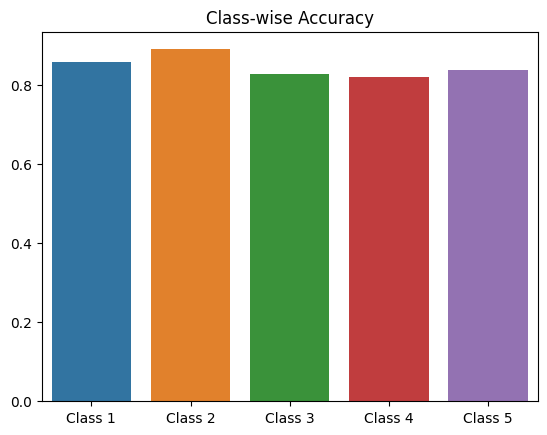

In [53]:
    # Plotting class-wise accuracy
    sns.barplot(x=['Class '+str(i+1) for i in range(len(class_wise_accuracy))], y=class_wise_accuracy)
    plt.title('Class-wise Accuracy')
    plt.show()

# Logs

In [58]:
wandb.finish()

F1 score (Max),▁
mean_acc,▁
roc_score,▁
F1 score (Max),0.7243
mean_acc,0.84678
roc_score,0.84284


In [54]:
with open('logs/resnet101_test_logs.json') as f:
    data = json.load(f)

test_logs = dict(data)

In [57]:
wandb.log(test_logs)

# References 

[1]	ECG plot: https://github.com/dy1901/ecg_plot

